In [1]:
from github import Github, ContentFile
from github.Repository import Repository
import zipfile
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

from typing import List

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger('urllib3').setLevel(logging.INFO)
logging.getLogger('github').setLevel(logging.INFO)
log = logging.getLogger(__name__)

In [3]:
GITHUB_TOKEN = os.getenv('GITHUB_PUBLIC_READ_TOKEN')
assert GITHUB_TOKEN is not None

In [4]:
CSV_PATH = 'CSV'
GITHUB_REPO = 'CSSEGISandData/COVID-19'

def get_csvs():
    g = Github(login_or_token=GITHUB_TOKEN)
    repo = g.get_repo(GITHUB_REPO)
    c = repo.get_contents('csse_covid_19_data/csse_covid_19_daily_reports')

    local_csvs = glob.glob(os.path.join(CSV_PATH, '*.csv'))
    local_csvs = list(map(os.path.basename, local_csvs))
    need_dowload = [f for f in c if f.path.endswith('.csv') and os.path.basename(f.path) not in local_csvs]
    for cf in need_dowload:
        fn = os.path.basename(cf.path)
        log.info(f'writing {fn}')
        with open(os.path.join(CSV_PATH, fn), 'wb') as f:
            f.write(cf.decoded_content)

In [5]:
get_csvs()

In [6]:
def path_to_date(path):
    path = os.path.basename(path)
    path = os.path.splitext(path)[0]
    date = pd.Timestamp(f'{path[-4:]}-{path[:2]}-{path[3:5]}')
    return date

def df_from_csv(path):
    column_info = {
        'FIPS': '',
        'Admin2': '',
        'Province_State': 'Province/State',
        'Country_Region': 'Country/Region',
        'Last_Update': 'Last Update',
        'Lat': 'Latitude',
        'Long_': 'Longitude',
        'Confirmed': 'Confirmed',
        'Deaths': 'Deaths',
        'Recovered': 'Recovered',
        'Active': '',
        'Combined_Key': '',
    }

    def combined_key(row):
        keys = ['Admin2', 'Province_State', 'Country_Region']
        values = [row[key] for key in keys]
        r = ', '.join((v for v in values if v and pd.notna(v)))
        return r

    log.debug(f'reading {path}')
    df = pd.read_csv(path)
    df['Date'] = path_to_date(path)
    column_names = list(df.columns)
    for column_name, old_column_name in column_info.items():
        if column_name in column_names:
            continue
        if old_column_name:
            if old_column_name in column_names:
                log.debug(f'{path}: renaming {old_column_name} to {column_name}')
                df.rename(columns={old_column_name: column_name}, inplace=True)
                continue
            else:
                log.debug(f'{path}: adding missing column {column_name}')
                df[column_name] = np.nan
                continue
        if column_name in ['FIPS', 'Admin2']:
            log.debug(f'{path}: adding missing column {column_name}')
            df[column_name] = np.nan
        elif column_name == 'Active':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
        elif column_name == 'Combined_Key':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Combined_Key'] = df.apply(combined_key, axis=1)
        else:
            raise NotImplementedError(f'Unexpected column name: {column_name}')

    return df

In [7]:
csv_files = glob.glob(os.path.join(CSV_PATH, '*.csv'))
csv_files.sort(reverse=True)
covid = pd.concat(df_from_csv(csv_file) for csv_file in csv_files)

In [8]:
print(covid.columns)
covid.head(2)

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio', 'Date'],
      dtype='object')


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,Date
0,45001.0,Abbeville,South Carolina,US,2020-06-17 04:33:21,34.223334,-82.461707,73.0,0.0,0.0,73.0,"Abbeville, South Carolina, US",297.631182,0.000000,2020-06-16
1,22001.0,Acadia,Louisiana,US,2020-06-17 04:33:21,30.295065,-92.414197,604.0,32.0,0.0,572.0,"Acadia, Louisiana, US",973.486985,5.298013,2020-06-16


Looks like 'China' and 'Mainland China' are (almost) equivalent. But the dates overlap

In [9]:
china = covid[covid.Country_Region=='China']
mainland_china = covid[covid.Country_Region=='Mainland China']
print(china.Province_State.unique())
print(mainland_china.Province_State.unique())
print(china.Date.describe())
print(mainland_china.Date.describe())

['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
['Gansu' 'Hebei' 'Hubei' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui'
 'Jiangxi' 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang'
 'Beijing' 'Shanghai' 'Fujian' 'Guangxi' 'Shaanxi' 'Yunnan' 'Hainan'
 'Guizhou' 'Tianjin' 'Shanxi' 'Liaoning' 'Jilin' 'Xinjiang'
 'Inner Mongolia' 'Ningxia' 'Qinghai' 'Tibet']
count                    3234
unique                     98
top       2020-06-14 00:00:00
freq                       33
first     2020-03-11 00:00:00
last      2020-06-16 00:00:00
Name: Date, dtype: object
count                    1517
unique                     51
top       2020-01-31 00:00:00
freq                       31
first     2020-01-22

Take a look at the 'Mainland China' records which overlap with the 'China' records

In [10]:
first_china = china.Date.min()
print(f"'China' records start at {first_china}")
overlapping_mainland = mainland_china[mainland_china.Date>=first_china]
print(overlapping_mainland)

'China' records start at 2020-03-11 00:00:00
     FIPS Admin2 Province_State  Country_Region          Last_Update      Lat  \
211   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
212   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   
206   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
207   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   

        Long_  Confirmed  Deaths  Recovered  Active           Combined_Key  \
211  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
212  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   
206  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
207  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   

     Incidence_Rate  Case-Fatality_Ratio       Date  
211             NaN                  NaN 2020-03-12  
212             NaN                  NaN 2020-03-1

Looks like the 'Mainland China' records which overlap with the 'China' records don't have numbers for Confirmed, Deaths, Recovered, or Active. We might as well get rid of them and then rename 'Mainland China' to 'China'

In [11]:
covid.drop(covid[(covid.Country_Region=='Mainland China') & (covid.Date>=first_china)].index, inplace=True)
covid.loc[covid.Country_Region=='Mainland China', 'Country_Region'] = 'China'

Also 'South Korea" and 'Korea, South' seem to be redundant. But there is no overlap

In [12]:
s_korea = covid[covid.Country_Region == 'South Korea']
ro_korea = covid[covid.Country_Region == 'Republic of Korea']
korea_s = covid[covid.Country_Region == 'Korea, South']
print('s_korea:')
print(s_korea.Date.describe())
print('ro_korea:')
print(ro_korea.Date.describe())
print('korea_s:')
print(korea_s.Date.describe())


s_korea:
count                      48
unique                     48
top       2020-02-17 00:00:00
freq                        1
first     2020-01-22 00:00:00
last      2020-03-09 00:00:00
Name: Date, dtype: object
ro_korea:
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object
korea_s:
count                      98
unique                     98
top       2020-03-13 00:00:00
freq                        1
first     2020-03-11 00:00:00
last      2020-06-16 00:00:00
Name: Date, dtype: object


Replace 'South Korea' and 'Republic of Korea' with 'Korea, South'

In [13]:
covid.loc[covid.Country_Region.isin(['South Korea', 'Republic of Korea']), 'Country_Region'] = 'Korea, South'

Finally 'Iran' and 'Iran (Islamic Republic of)' seem to be redundant

In [14]:
iran = covid[covid.Country_Region == 'Iran']
iran_r= covid[covid.Country_Region == 'Iran (Islamic Republic of)']
print(iran.Date.describe())
print(iran_r.Date.describe())

count                     118
unique                    118
top       2020-03-13 00:00:00
freq                        1
first     2020-02-19 00:00:00
last      2020-06-16 00:00:00
Name: Date, dtype: object
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object


In [15]:
covid.loc[covid.Country_Region == 'Iran (Islamic Republic of)', 'Country_Region'] = 'Iran'

In [16]:
# set defaults for Deaths, Recovered, and Confirmed
for c in ['Deaths', 'Recovered', 'Confirmed']:
    covid[c].fillna(value=0, inplace=True)

covid.Active.fillna(covid.Confirmed - covid.Deaths - covid.Recovered, inplace = True)

In [17]:
active_wrong = covid[covid.Active != (covid.Confirmed-covid.Deaths-covid.Recovered)]
active_wrong

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,Date
3431,NaN,NaN,Recovered,US,2020-06-17 04:33:21,NaN,NaN,0.0,0.0,583503.0,-655539.0,"Recovered, US",NaN,NaN,2020-06-16
3433,NaN,NaN,Recovered,US,2020-06-16 04:33:09,NaN,NaN,0.0,0.0,576334.0,-649310.0,"Recovered, US",NaN,NaN,2020-06-15
3428,NaN,NaN,Recovered,US,2020-06-15 03:33:14,NaN,NaN,0.0,0.0,561816.0,-630333.0,"Recovered, US",NaN,NaN,2020-06-14
3428,NaN,NaN,Recovered,US,2020-06-14 03:33:15,NaN,NaN,0.0,0.0,556606.0,-626277.0,"Recovered, US",NaN,NaN,2020-06-13
3425,NaN,NaN,Recovered,US,2020-06-13 03:33:14,NaN,NaN,0.0,0.0,547386.0,-621891.0,"Recovered, US",NaN,NaN,2020-06-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186,NaN,NaN,Prince Edward Island,Canada,3/22/20 23:48,46.510700,-63.416800,3.0,0.0,0.0,0.0,"Prince Edward Island, Canada",NaN,NaN,2020-03-22
3187,NaN,NaN,Northwest Territories,Canada,3/22/20 23:48,NaN,NaN,1.0,0.0,0.0,0.0,"Northwest Territories, Canada",NaN,NaN,2020-03-22
3188,NaN,NaN,Diamond Princess,Canada,3/22/20 23:48,0.000000,0.000000,0.0,1.0,0.0,0.0,"Diamond Princess, Canada",NaN,NaN,2020-03-22
3415,11001.0,District of Columbia,District of Columbia,US,3/22/20 23:45,38.904178,-77.016560,102.0,2.0,0.0,0.0,"District of Columbia,District of Columbia,US",NaN,NaN,2020-03-22


In [18]:
covid.Active = covid.Confirmed-covid.Deaths-covid.Recovered

We only want to work on sums per country and date and the dataframe will be indexed by country and date


In [19]:
covid = covid.drop(columns=['FIPS', 'Lat', 'Long_']).groupby(by=['Country_Region', 'Date']).sum()

In [20]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19804 entries, (' Azerbaijan', Timestamp('2020-02-28 00:00:00')) to ('occupied Palestinian territory', Timestamp('2020-03-17 00:00:00'))
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            19804 non-null  float64
 1   Deaths               19804 non-null  float64
 2   Recovered            19804 non-null  float64
 3   Active               19804 non-null  float64
 4   Incidence_Rate       19804 non-null  float64
 5   Case-Fatality_Ratio  19804 non-null  float64
dtypes: float64(6)
memory usage: 1008.8+ KB


In [21]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
 Azerbaijan    2020-02-28        1.0     0.0        0.0     1.0   
Afghanistan    2020-02-24        1.0     0.0        0.0     1.0   
               2020-02-25        1.0     0.0        0.0     1.0   
               2020-02-26        1.0     0.0        0.0     1.0   
               2020-02-27        1.0     0.0        0.0     1.0   

                           Incidence_Rate  Case-Fatality_Ratio  
Country_Region Date                                             
 Azerbaijan    2020-02-28             0.0                  0.0  
Afghanistan    2020-02-24             0.0                  0.0  
               2020-02-25             0.0                  0.0  
               2020-02-26             0.0                  0.0  
               2020-02-27             0.0                  0.0

Get top n impacted countries

In [22]:
N_TOP_IMPACTED = 50
top_impacted = covid.groupby(level=0).max().Confirmed.nlargest(n=N_TOP_IMPACTED).index
top_impacted

Index(['US', 'Brazil', 'Russia', 'India', 'United Kingdom', 'Spain', 'Italy',
       'Peru', 'France', 'Iran', 'Germany', 'Chile', 'Turkey', 'Mexico',
       'Pakistan', 'Saudi Arabia', 'Canada', 'Bangladesh', 'China', 'Qatar',
       'South Africa', 'Belgium', 'Belarus', 'Sweden', 'Colombia',
       'Netherlands', 'Ecuador', 'Egypt', 'United Arab Emirates', 'Singapore',
       'Indonesia', 'Portugal', 'Kuwait', 'Argentina', 'Ukraine',
       'Switzerland', 'Poland', 'Philippines', 'Afghanistan', 'Ireland',
       'Oman', 'Dominican Republic', 'Iraq', 'Romania', 'Panama', 'Bolivia',
       'Bahrain', 'Israel', 'Armenia', 'Japan'],
      dtype='object', name='Country_Region')

Get population data. Data from https://data.worldbank.org/indicator/sp.pop.totl

In [23]:
def read_population_un():
    """
    read population data obtained from https://population.un.org/wpp/Download/Standard/CSV/
    :return:
    """
    df = pd.read_csv('WPP2019_TotalPopulationBySex.csv', header=0)
    df = df[df.Time==2019]
    df = df.set_index('Location')
    df['population'] = df.PopTotal * 1000
    return df

population = read_population_un()
population.info()


<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, Afghanistan to Zimbabwe
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocID       477 non-null    int64  
 1   VarID       477 non-null    int64  
 2   Variant     477 non-null    object 
 3   Time        477 non-null    int64  
 4   MidPeriod   477 non-null    float64
 5   PopMale     443 non-null    float64
 6   PopFemale   443 non-null    float64
 7   PopTotal    477 non-null    float64
 8   PopDensity  477 non-null    float64
 9   population  477 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 41.0+ KB


In [24]:
population.loc['Germany']

LocID                276
VarID                  2
Variant           Medium
Time                2019
MidPeriod         2019.5
PopMale          41249.1
PopFemale        42267.9
PopTotal           83517
PopDensity       239.606
population    8.3517e+07
Name: Germany, dtype: object

We want to relate the numbers of the top impacted countries to their population.

Do we have population data for all top impacted countries?

In [25]:
missing_countries = [c for c in top_impacted if c not in population.index]
missing_countries

['US', 'Russia', 'Iran', 'Bolivia']

In [26]:
print('\n'.join(c for c in population.index if 'United States' in c))
print()
print('\n'.join(c for c in population.index if 'Iran' in c))
print()
print('\n'.join(c for c in population.index if 'Russia' in c))
print()
print('\n'.join(c for c in population.index if 'Korea' in c))
print()
print('\n'.join(c for c in population.index if 'Boli' in c))

United States Virgin Islands
United States of America
United States of America (and dependencies)

Iran (Islamic Republic of)

Russian Federation

Dem. People's Republic of Korea
Republic of Korea

Bolivarian Alliance for the Americas (ALBA)
Bolivia (Plurinational State of)
Venezuela (Bolivarian Republic of)


Looks like we can use
* 'United States of America' for 'US'
* 'Iran (Islamic Republic of)' for 'Iran'
* 'Russian Federation' for 'Russia'
* 'Republic of Korea' for 'Korea, South'

For simplicity reasons we simply change the values in the population dataset

In [27]:
mapper = {
    'United States of America': 'US',
    'Iran (Islamic Republic of)': 'Iran',
    'Russian Federation': 'Russia',
    'Republic of Korea': 'Korea, South',
    'Bolivia (Plurinational State of)':'Bolivia'}
population.rename(mapper=mapper, inplace=True)
missing_countries = [c for c in top_impacted if c not in population.index]
assert not missing_countries, f'missing: {missing_countries}'

Continue to work only with these top impacted countries.

In [28]:
covid = covid.loc[top_impacted]

Add values relative to population size

In [29]:
for c in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    covid[f'{c}_per_100k'] = covid[c] / population.loc[covid.index.get_level_values('Country_Region')].PopTotal.values * 100

In [30]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5923 entries, ('Afghanistan', Timestamp('2020-02-24 00:00:00')) to ('United Kingdom', Timestamp('2020-06-16 00:00:00'))
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            5923 non-null   float64
 1   Deaths               5923 non-null   float64
 2   Recovered            5923 non-null   float64
 3   Active               5923 non-null   float64
 4   Incidence_Rate       5923 non-null   float64
 5   Case-Fatality_Ratio  5923 non-null   float64
 6   Confirmed_per_100k   5923 non-null   float64
 7   Deaths_per_100k      5923 non-null   float64
 8   Recovered_per_100k   5923 non-null   float64
 9   Active_per_100k      5923 non-null   float64
dtypes: float64(10)
memory usage: 489.0+ KB


In [31]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Afghanistan    2020-02-24        1.0     0.0        0.0     1.0   
               2020-02-25        1.0     0.0        0.0     1.0   
               2020-02-26        1.0     0.0        0.0     1.0   
               2020-02-27        1.0     0.0        0.0     1.0   
               2020-02-28        1.0     0.0        0.0     1.0   

                           Incidence_Rate  Case-Fatality_Ratio  \
Country_Region Date                                              
Afghanistan    2020-02-24             0.0                  0.0   
               2020-02-25             0.0                  0.0   
               2020-02-26             0.0                  0.0   
               2020-02-27             0.0                  0.0   
               2020-02-28             0.0                  0.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Afghanistan    2020-02-24            0.002629              0.0   
               2020-02-25            0.002629              0.0   
               2020-02-26            0.002629              0.0   
               2020-02-27            0.002629              0.0   
               2020-02-28            0.002629              0.0   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Afghanistan    2020-02-24                 0.0         0.002629  
               2020-02-25                 0.0         0.002629  
               2020-02-26                 0.0         0.002629  
               2020-02-27                 0.0         0.002629  
               2020-02-28                 0.0         0.002629

In [32]:
covid_max = covid.groupby(level='Country_Region').max()
covid_max['population'] = population.loc[covid_max.index].PopTotal * 1000
covid_max['recovered_per_confirmed'] = covid_max.Recovered / covid_max.Confirmed
covid_max['deaths_per_confirmed'] = covid_max.Deaths / covid_max.Confirmed
covid_max.info()
covid_max

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Afghanistan to United Kingdom
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Confirmed                50 non-null     float64
 1   Deaths                   50 non-null     float64
 2   Recovered                50 non-null     float64
 3   Active                   50 non-null     float64
 4   Incidence_Rate           50 non-null     float64
 5   Case-Fatality_Ratio      50 non-null     float64
 6   Confirmed_per_100k       50 non-null     float64
 7   Deaths_per_100k          50 non-null     float64
 8   Recovered_per_100k       50 non-null     float64
 9   Active_per_100k          50 non-null     float64
 10  population               50 non-null     float64
 11  recovered_per_confirmed  50 non-null     float64
 12  deaths_per_confirmed     50 non-null     float64
dtypes: float64(13)
memory usage: 5.5+ KB


,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio,Confirmed_per_100k,Deaths_per_100k,Recovered_per_100k,Active_per_100k,population,recovered_per_confirmed,deaths_per_confirmed
Country_Region,,,,,,,,,,,,,
Afghanistan,26310.0,491.0,5508.0,20311.0,6.758572e+01,1.901801,69.160843,1.290687,14.478827,53.391330,3.804176e+07,0.209350,0.018662
Argentina,34159.0,878.0,10174.0,23107.0,7.558007e+01,3.372463,76.280672,1.960667,22.719622,51.600383,4.478068e+07,0.297842,0.025703
Armenia,17489.0,293.0,6571.0,10625.0,5.901998e+02,1.688371,591.298456,9.906252,222.163769,359.228435,2.957728e+06,0.375722,0.016753
Bahrain,19553.0,47.0,13866.0,5700.0,1.149106e+03,0.241940,1191.410487,2.863821,844.888140,347.314467,1.641164e+06,0.709149,0.002404
Bangladesh,94481.0,1262.0,36264.0,70679.0,5.736921e+01,1.378491,57.947389,0.774014,22.241552,43.349070,1.630462e+08,0.383823,0.013357
Belarus,55369.0,318.0,31273.0,25477.0,5.859574e+02,0.574329,585.766020,3.364222,330.846877,269.529175,9.452409e+06,0.564811,0.005743
Belgium,60155.0,9663.0,16625.0,33867.0,5.190422e+02,16.247214,521.304277,83.739726,144.072539,293.492012,1.153933e+07,0.276369,0.160635
Bolivia,19883.0,659.0,3752.0,15472.0,1.703328e+02,3.437017,172.698896,5.723914,32.588958,134.386024,1.151310e+07,0.188704,0.033144
Brazil,923189.0,45241.0,490005.0,387943.0,1.677592e+04,108.109277,437.427673,21.436201,232.175369,183.816102,2.110495e+08,0.530774,0.049005


In [33]:
covid_max.sort_values(by='Confirmed',ascending=False).loc[:,['Confirmed', 'Deaths']]

,Confirmed,Deaths
Country_Region,,
US,2136965.0,116955.0
Brazil,923189.0,45241.0
Russia,544725.0,7274.0
India,354065.0,11903.0
United Kingdom,299600.0,42054.0
Spain,244328.0,28752.0
Italy,237500.0,34405.0
Peru,237156.0,7056.0
France,194347.0,29550.0


In [34]:
covid_max.sort_values(by='Confirmed_per_100k',ascending=False).loc[:,['Confirmed_per_100k', 'Confirmed', 'Deaths']]

,Confirmed_per_100k,Confirmed,Deaths
Country_Region,,,
Qatar,2898.126495,82077.0,80.0
Bahrain,1191.410487,19553.0,47.0
Chile,973.241132,184449.0,3383.0
Kuwait,878.472155,36958.0,303.0
Peru,729.475945,237156.0,7056.0
Singapore,705.833546,40969.0,26.0
US,649.405297,2136965.0,116955.0
Armenia,591.298456,17489.0,293.0
Belarus,585.766020,55369.0,318.0


In [35]:
covid_max.sort_values(by='deaths_per_confirmed',ascending=False).loc[:,['Confirmed', 'Deaths', 'deaths_per_confirmed']]

,Confirmed,Deaths,deaths_per_confirmed
Country_Region,,,
Belgium,60155.0,9663.0,0.160635
France,194347.0,29550.0,0.152048
Italy,237500.0,34405.0,0.144863
United Kingdom,299600.0,42054.0,0.140367
Netherlands,49295.0,6089.0,0.123522
Mexico,154863.0,18310.0,0.118234
Spain,244328.0,28752.0,0.117678
Sweden,53323.0,4939.0,0.092624
Ecuador,47943.0,3970.0,0.082807


In [36]:
covid.columns

Index(['Confirmed', 'Deaths', 'Recovered', 'Active', 'Incidence_Rate',
       'Case-Fatality_Ratio', 'Confirmed_per_100k', 'Deaths_per_100k',
       'Recovered_per_100k', 'Active_per_100k'],
      dtype='object')

In [37]:
covid.drop(columns=['Incidence_Rate','Case-Fatality_Ratio'], inplace=True)

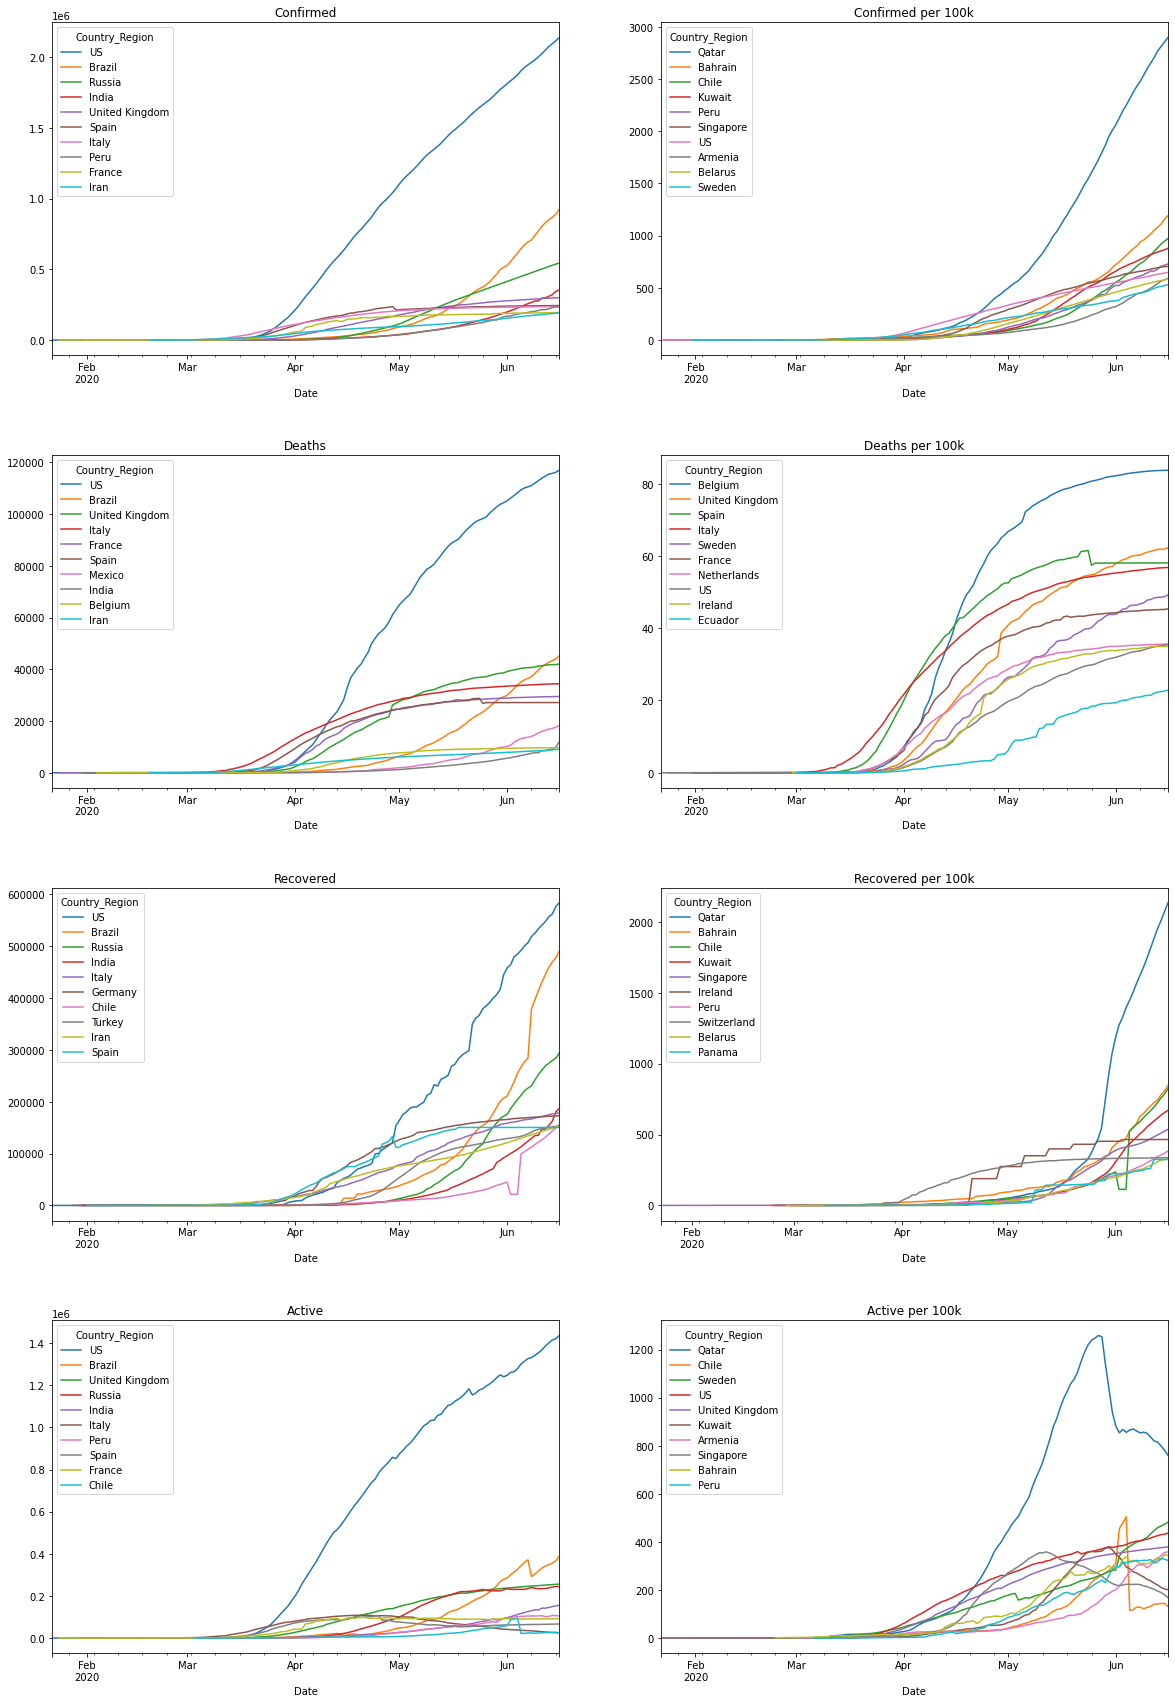

In [38]:
fig, axes = plt.subplots(4, 2, figsize=(20,30))
for i, column in enumerate(covid.columns):
    ax_r = i % 4
    ax_c = int(i/4)
    ax = axes[ax_r, ax_c]
    top_countries = covid_max.nlargest(n=10, columns=column, keep='all').sort_values(by=column, ascending=False).index
    p = covid.loc[top_countries]
    p = p.pivot_table(index=p.index.get_level_values('Date'), 
                      columns=p.index.get_level_values('Country_Region'), 
                      values=column)

    p = p.reindex(columns=top_countries)
    p.plot(title=column.replace('_', ' '), logy=False, ax=ax)

fig.subplots_adjust(hspace=0.3)

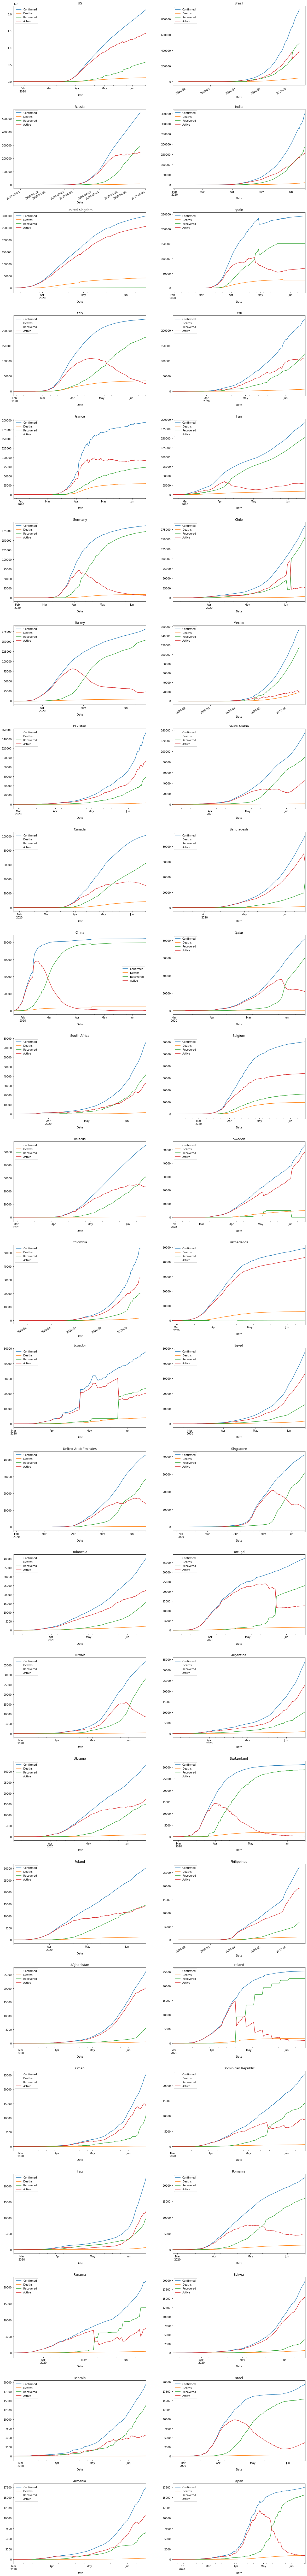

In [39]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country].plot(y=['Confirmed', 'Deaths', 'Recovered', 'Active'], 
                            ax = ax, title=country, logy=False)
    

fig.subplots_adjust(hspace=0.3)

We want to add columns with differences. To smooth the differences we calculate the differences on a rolling window (size 5)

In [40]:
d=covid.groupby(level='Country_Region').rolling(window=5).mean().diff()
d

Confirmed  Deaths  Recovered  \
Country_Region Country_Region Date                                       
Afghanistan    Afghanistan    2020-02-24        NaN     NaN        NaN   
                              2020-02-25        NaN     NaN        NaN   
                              2020-02-26        NaN     NaN        NaN   
                              2020-02-27        NaN     NaN        NaN   
                              2020-02-28        NaN     NaN        NaN   
...                                             ...     ...        ...   
United Kingdom United Kingdom 2020-06-12     1356.2   188.2        8.6   
                              2020-06-13     1398.8   213.4        5.6   
                              2020-06-14     1352.2   163.0        5.2   
                              2020-06-15     1345.4   121.6        3.0   
                              2020-06-16     1348.0   138.0        3.0   

                                          Active  Confirmed_per_100k  \
Country_Region Country_Region Date                                     
Afghanistan    Afghanistan    2020-02-24     NaN                 NaN   
                              2020-02-25     NaN                 NaN   
                              2020-02-26     NaN                 NaN   
                              2020-02-27     NaN                 NaN   
                              2020-02-28     NaN                 NaN   
...                                          ...                 ...   
United Kingdom United Kingdom 2020-06-12  1159.4            2.008288   
                              2020-06-13  1179.8            2.071371   
                              2020-06-14  1184.0            2.002365   
                              2020-06-15  1220.8            1.992295   
                              2020-06-16  1207.0            1.996145   

                                          Deaths_per_100k  Recovered_per_100k  \
Country_Region Country_Region Date                                              
Afghanistan    Afghanistan    2020-02-24              NaN                 NaN   
                              2020-02-25              NaN                 NaN   
                              2020-02-26              NaN                 NaN   
                              2020-02-27              NaN                 NaN   
                              2020-02-28              NaN                 NaN   
...                                                   ...                 ...   
United Kingdom United Kingdom 2020-06-12         0.278690            0.012735   
                              2020-06-13         0.316007            0.008293   
                              2020-06-14         0.241374            0.007700   
                              2020-06-15         0.180068            0.004442   
                              2020-06-16         0.204353            0.004442   

                                          Active_per_100k  
Country_Region Country_Region Date                         
Afghanistan    Afghanistan    2020-02-24              NaN  
                              2020-02-25              NaN  
                              2020-02-26              NaN  
                              2020-02-27              NaN  
                              2020-02-28              NaN  
...                                                   ...  
United Kingdom United Kingdom 2020-06-12         1.716862  
                              2020-06-13         1.747071  
                              2020-06-14         1.753291  
                              2020-06-15         1.807785  
                              2020-06-16         1.787350  

[5923 rows x 8 columns]

For some reason the 1st index level is duplicated

In [41]:
d = d.reset_index(level=0, drop=True)
d

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Afghanistan    2020-02-24        NaN     NaN        NaN     NaN   
               2020-02-25        NaN     NaN        NaN     NaN   
               2020-02-26        NaN     NaN        NaN     NaN   
               2020-02-27        NaN     NaN        NaN     NaN   
               2020-02-28        NaN     NaN        NaN     NaN   
...                              ...     ...        ...     ...   
United Kingdom 2020-06-12     1356.2   188.2        8.6  1159.4   
               2020-06-13     1398.8   213.4        5.6  1179.8   
               2020-06-14     1352.2   163.0        5.2  1184.0   
               2020-06-15     1345.4   121.6        3.0  1220.8   
               2020-06-16     1348.0   138.0        3.0  1207.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Afghanistan    2020-02-24                 NaN              NaN   
               2020-02-25                 NaN              NaN   
               2020-02-26                 NaN              NaN   
               2020-02-27                 NaN              NaN   
               2020-02-28                 NaN              NaN   
...                                       ...              ...   
United Kingdom 2020-06-12            2.008288         0.278690   
               2020-06-13            2.071371         0.316007   
               2020-06-14            2.002365         0.241374   
               2020-06-15            1.992295         0.180068   
               2020-06-16            1.996145         0.204353   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Afghanistan    2020-02-24                 NaN              NaN  
               2020-02-25                 NaN              NaN  
               2020-02-26                 NaN              NaN  
               2020-02-27                 NaN              NaN  
               2020-02-28                 NaN              NaN  
...                                       ...              ...  
United Kingdom 2020-06-12            0.012735         1.716862  
               2020-06-13            0.008293         1.747071  
               2020-06-14            0.007700         1.753291  
               2020-06-15            0.004442         1.807785  
               2020-06-16            0.004442         1.787350  

[5923 rows x 8 columns]

Verify that the rolling values get reset at the country boundaries

In [42]:
len_of_first_group = d.loc[d.index.get_level_values(0)[0]].shape[0]
len_of_first_group

114

In [43]:
d.iloc[len_of_first_group-5:len_of_first_group+10]

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Afghanistan    2020-06-12      640.8    17.8      410.6   212.4   
               2020-06-13      637.0    16.4      406.0   214.6   
               2020-06-14      661.4    17.4      414.8   229.2   
               2020-06-15      677.0    14.6      430.2   232.2   
               2020-06-16      684.0    13.0      436.4   234.6   
Argentina      2020-03-03        NaN     NaN        NaN     NaN   
               2020-03-04        NaN     NaN        NaN     NaN   
               2020-03-05        NaN     NaN        NaN     NaN   
               2020-03-06        NaN     NaN        NaN     NaN   
               2020-03-07        NaN     NaN        NaN     NaN   
               2020-03-08        2.2     0.2        0.0     2.0   
               2020-03-09        2.2     0.2        0.0     2.0   
               2020-03-10        3.2     0.2        0.0     3.0   
               2020-03-11        3.4     0.2        0.0     3.2   
               2020-03-12        2.2     0.2        0.0     2.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Afghanistan    2020-06-12            1.684465         0.046791   
               2020-06-13            1.674476         0.043111   
               2020-06-14            1.738616         0.045739   
               2020-06-15            1.779623         0.038379   
               2020-06-16            1.798024         0.034173   
Argentina      2020-03-03                 NaN              NaN   
               2020-03-04                 NaN              NaN   
               2020-03-05                 NaN              NaN   
               2020-03-06                 NaN              NaN   
               2020-03-07                 NaN              NaN   
               2020-03-08            0.004913         0.000447   
               2020-03-09            0.004913         0.000447   
               2020-03-10            0.007146         0.000447   
               2020-03-11            0.007593         0.000447   
               2020-03-12            0.004913         0.000447   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Afghanistan    2020-06-12            1.079340         0.558334  
               2020-06-13            1.067248         0.564117  
               2020-06-14            1.090381         0.602496  
               2020-06-15            1.130863         0.610382  
               2020-06-16            1.147160         0.616691  
Argentina      2020-03-03                 NaN              NaN  
               2020-03-04                 NaN              NaN  
               2020-03-05                 NaN              NaN  
               2020-03-06                 NaN              NaN  
               2020-03-07                 NaN              NaN  
               2020-03-08            0.000000         0.004466  
               2020-03-09            0.000000         0.004466  
               2020-03-10            0.000000         0.006699  
               2020-03-11            0.000000         0.007146  
               2020-03-12            0.000000         0.004466

In [44]:
covid=covid.join(other=d,rsuffix='_diff')
covid.iloc[80:95]

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Afghanistan    2020-05-14     5639.0   136.0      691.0   4812.0   
               2020-05-15     6053.0   153.0      745.0   5155.0   
               2020-05-16     6402.0   168.0      745.0   5489.0   
               2020-05-17     6664.0   169.0      778.0   5717.0   
               2020-05-18     7072.0   173.0      801.0   6098.0   
               2020-05-19     7653.0   178.0      850.0   6625.0   
               2020-05-20     8145.0   187.0      930.0   7028.0   
               2020-05-21     8676.0   193.0      938.0   7545.0   
               2020-05-22     9216.0   205.0      996.0   8015.0   
               2020-05-23     9998.0   216.0     1040.0   8742.0   
               2020-05-24    10582.0   218.0     1075.0   9289.0   
               2020-05-25    11173.0   219.0     1097.0   9857.0   
               2020-05-26    11831.0   220.0     1128.0  10483.0   
               2020-05-27    12456.0   227.0     1138.0  11091.0   
               2020-05-28    13036.0   235.0     1209.0  11592.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Afghanistan    2020-05-14           14.823185         0.357502   
               2020-05-15           15.911463         0.402190   
               2020-05-16           16.828876         0.441620   
               2020-05-17           17.517593         0.444249   
               2020-05-18           18.590098         0.454763   
               2020-05-19           20.117367         0.467907   
               2020-05-20           21.410683         0.491565   
               2020-05-21           22.806518         0.507337   
               2020-05-22           24.226010         0.538882   
               2020-05-23           26.281646         0.567797   
               2020-05-24           27.816801         0.573054   
               2020-05-25           29.370357         0.575683   
               2020-05-26           31.100036         0.578312   
               2020-05-27           32.742967         0.596713   
               2020-05-28           34.267608         0.617742   

                           Recovered_per_100k  Active_per_100k  \
Country_Region Date                                              
Afghanistan    2020-05-14            1.816425        12.649258   
               2020-05-15            1.958374        13.550899   
               2020-05-16            1.958374        14.428881   
               2020-05-17            2.045121        15.028223   
               2020-05-18            2.105581        16.029754   
               2020-05-19            2.234387        17.415074   
               2020-05-20            2.444682        18.474436   
               2020-05-21            2.465712        19.833469   
               2020-05-22            2.618176        21.068953   
               2020-05-23            2.733838        22.980011   
               2020-05-24            2.825842        24.417905   
               2020-05-25            2.883673        25.911001   
               2020-05-26            2.965163        27.556561   
               2020-05-27            2.991450        29.154805   
               2020-05-28            3.178087        30.471779   

                           Confirmed_diff  Deaths_diff  Recovered_diff  \
Country_Region Date                                                      
Afghanistan    2020-05-14           321.2          4.2            37.8   
               2020-05-15           330.2          6.6            37.4   
               2020-05-16           343.0          9.2            37.4   
               2020-05-17           340.2          8.4            33.6   
               2020-05-18           369.2          8.2            30.6   
               2020-05-19           402.8          8.4            31.8   
               2020-05-20       

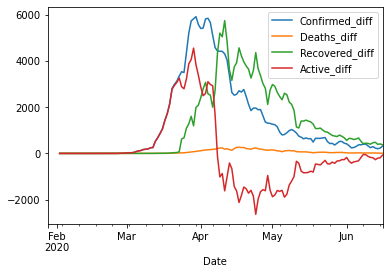

In [45]:
covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].plot()

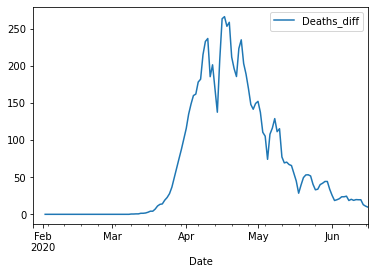

In [46]:
covid.loc[('Germany',),['Deaths_diff']].plot()

In [47]:
display(HTML(covid.loc[('Germany',),['Deaths','Deaths_diff']].to_html()))

,Deaths,Deaths_diff
Date,,
2020-01-28,0.0,NaN
2020-01-29,0.0,NaN
2020-01-30,0.0,NaN
2020-01-31,0.0,NaN
2020-02-01,0.0,NaN
2020-02-02,0.0,0.0
2020-02-03,0.0,0.0
2020-02-04,0.0,0.0
2020-02-05,0.0,0.0


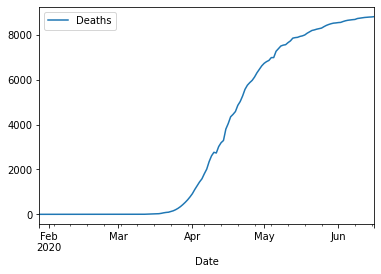

In [48]:
covid.loc[('Germany',),['Deaths']].plot()